Использую архитектуру transformer. Появившись для решения задач машинного обучения, затем как часто это бывает, такую нейросеть стали применять для решения других задач, на других данных, в частности на временных рядов. Данная архитектура позволяет признакам выражать себя через самих себя и через другие признаки. Звучит странно. Но представьте, загнали мы в модель какие то признаки и пытаемся с их помощь аппроксимировать целевой признак — тут модель ограниченна строгим набором признаков которые вы ей подали. А теперь представим что в процессе обучения, нейросеть может каждый признак представить через себя и через другие признаки с какими то весами, и эти веса настраиваются в процессе обучения. Мы даем нейросети возможность игнорировать признаки (например если признак А мы представим как А*0 + Б*0,4 + В*0,6 то признак А исчезнет, потому что теперь это нечто состоящее из признаков Б и В). Кроме того, таким образом мы устраняем шум в признаке, выражая его через другие признаки, и наоборот, выражая признак через самого себя с весом 0,99, мы как бы подтверждаем что для задачи аппроксимации признак А нужно брать таким как он подается.
Ну и немножко истории, как из задачи машинного перевода мы докатились до трансформеров. При машинном переводе у нас слева стоит предложение на 1 языке, справа на другом, и нужно найти алгоритм который успешно справится с переводом, при этом на входе и выходе число слов в предложении может не совпадать. То есть это модель SeqtoSeq. Логично решать ее с помощью рекуррентных сетей, которые считывают данные как человек читает предложение — последовательно, с каждым новым словом учитывая контекст предложения все лучше и лучше. А предложение сами понимаете, имеет  контекст, где каждое отдельно взятое слово можно выразить через самого себя, но и через другие слова в данном предложении. И вот пробежавшись по всему предложению от первого слова до последнего, наша рекуррентная сеть — кодер, получает какое то скрытое представление h которое подается декодеру который из этого скрытого состояния опять же, слово за словом разматывает его в предложение, но уже на другом языке. Затем додумались, что нужно использовать не только скрытое состояние после прочтения кодером всего предложения, но и скрытые состояния после прочтения каждого нового слова: скрытое состояние после прочтения первого слова, скрытое состояние после прочтения первого слова + второго итп итд, и назвали этот механизм attention. Предоставили нейросети самой определять какой скрытое состояние ей важней для перевода. В конце концов вышла статья что мол «All you need is love», ну то есть «Attention is all you need» в котором вообще отказались от рекуррентных нейросетей, перейдя к полносвязным слоям (кто то иронично называет это реваншем полносвязных слоев), назвав все это transformer. Но идея что в рекурентных сетях с attention что в трансформерах одна — мы даем нейросети в ее жажде что то там аппроксимировать, возможность залезть в наши признаки по локоть и самой выбирать их представление.
А сейчас я попробую провести параллели с фондовым рынком и машинным переводом, чтобы понять почему у трансформеров может получиться в предсказание цен на биржах.   
1. В архитектуре трансформеров есть такое слой как 'position encoding'. Мы как торгующие на бирже отлично понимает что если у нас есть ряд из Close то нельзя его перемешивать, потому что потеряется всяческий смысл. Цена пересекающая среднюю 10 баров назад и на последнем баре это разные вещи, но для сверточной сети это может быть одним и тем же.
2. Трансформеры в процессе обучения могут позволить себе забыть ненужные признаки, сделать более важными нужные, убрать шум из них. Но разве данные на рынке не высокошумовые? Нужных признаков на рынке на самом деле очень мало, и даже они сильно зашумлены, и подав кучу признаков неплохо иметь возможность убрать ненужные, так получается трансформеры идеально вписываются в эту концепцию.
3. Вся это идея с attention появилась из машинного перевода, где на вход подают логический массив — предложение. В чем его внутренняя логичность? Да в том что нельзя в предложении произвольно поменять слово, потому что оно связанно с другими словами, а если мы выкинем слово, то ты можем восстановить его по предложению (кстати на этом строится предобученые модели Bert). Ну так на рынке тоже существуют такие логические массивы — например день, неделя итп итд. Происходящее внутри дня имеет свою структуру, наступает следующий день и все повторяется вновь. Например, из-за дня в день объёмы торгов в первый час и последний максимальные. Поэтому мне кажется весьма логичным подавать данные имеющие внутреннюю структуру, и возможно, те у кого не получается использовать трансформеры на фондовых рынках упускают этот момент.

In [ ]:
! pip install investpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
 
from sklearn.preprocessing import MinMaxScaler
 
%matplotlib notebook
import matplotlib.pyplot as plt
 
import pandas as pd
 
from datetime import date
from datetime import datetime
import datetime

 
import os

import investpy

import random
 
%matplotlib inline
 

ModuleNotFoundError: ignored

### 1. Модель

In [ ]:
def attention(Q, K, V):
    m = torch.matmul(Q, K.transpose(2, 1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
 
    a = torch.softmax(m , -1) #(batch_size, dim_attn, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)
 
class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.query = Query(dim_val, dim_attn)
        self.key = Key(dim_val, dim_attn)
        self.value = Value(dim_val, dim_val)        
        
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q, K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
 
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
        
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        #self.fc2 = nn.Linear(5, dim_val)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x
 
class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        x = self.fc1(x)
        #x = self.fc2(x)
        
        return x
 
class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        #self.fc2 = nn.Linear(5, dim_attn)
    
    def forward(self, x):
        
        x = self.fc1(x)
        #print(x.shape)
        #x = self.fc2(x)
        
        return x
 
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
 
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
 
    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     
    
def get_data(data, batch_size, input_sequence_length, output_sequence_length, train=True):
  """
  train, test: np.array, shape(n, )
 
  """  
  i = input_sequence_length + output_sequence_length
  if train:
    t = torch.zeros(batch_size, 1).uniform_(0, len(instrument_data) - i).int()
  else:    
    batch_size = len(data) - i
    t = torch.arange(0, batch_size).reshape(-1, 1)
  
  b = torch.arange(0, i).unsqueeze(0).repeat(batch_size, 1) + t
  s = torch.FloatTensor(data[b])
  X, y = s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]
 
  return X, y

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, 
                 n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
        for enc in self.encs[1:]:
            e = enc(e)
        
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        
        return x

### 2. Гиперпраметры модели

In [ ]:
#hyperparams
enc_seq_len = 4#10
dec_seq_len = 4#4
output_sequence_length = 1
 
dim_val = 10
dim_attn = 9
input_size = 1 # число признаков
lr = 0.002
epochs = 5
 
n_heads = 3 
 
n_decoder_layers = 3
n_encoder_layers = 3
 
batch_size = 600
 
#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)
 
MY_FORCE = 10

DIR = 'dayUS/'
# stock = 'US1.TSLA_101201_201201.csv'
# stock = 'US1.FB_101201_201201.csv'
# stock = 'US1.AMZN_101201_201201.csv'
stock = 'US1.MSFT_101201_201201.csv'
# stock = 'SPFB.RTS.csv'
# stock = 'LKOH.csv'

### 3. Подготовка данных для модели

#### From csv

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x = x
       
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        # data = self.x[self.feature]
        # data = scaler.fit_transform(self.x)#[:(len(self.x) // self.batch)*self.batch]+1)
        return {'sampel': torch.tensor(self.x.iloc[idx, :], dtype=float)}

In [ ]:
# Пусть в DIR лежат файлы, каждый из которых это какая то компания. Формат стандартный: Open, High, Low, Close, Volume. Но заголовки могут писать вместо Close - <CLOSE>
def get_date(stock, DIR = DIR + 'Date/', Close = '<CLOSE>'):
  today = datetime.datetime.today().strftime('%d/%m/%Y')
  dataset = df[Close]  # Для модели нужен только Close
  # Делаем ряд стационарным
  scaler = MinMaxScaler()  
  dataset = scaler.fit_transform(np.array(dataset).reshape(-1, 1)).flatten()
  # Обратно в пандасовский датафрйем, мне просто так удобно
  dataset = pd.DataFrame(dataset)

  long = (enc_seq_len + output_sequence_length) 
  dataset_all = pd.DataFrame()

  for i in range(0, len(dataset) - long):
    dataset_all = pd.concat([dataset_all, pd.DataFrame((dataset[i:i + long].values)).T])

  feat = dataset_all.iloc[:,:-1]
  targ = dataset_all.iloc[:,-1:]

  len_ = int(len(feat)*0.7)
  X_train = feat.iloc[:len_]
  y_train = targ.iloc[:len_]
  X_test = feat.iloc[len_:]
  y_test = targ.iloc[len_:]


  our_dataset = RandomDataset(X_train)
  dataloader  = torch.utils.data.DataLoader(our_dataset, batch_size=1)
  return dataloader, dataloader_test, name, scaler

In [ ]:
def get_date(stock, DIR = DIR + 'Date/', Close = '<CLOSE>'):
  

In [ ]:
def get_dummy_data(x, close = '<CLOSE>'):
  # return np.cos(x)
  # return np.arange(1, 100, 1)
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/'+ DIR + stock)
  print(type(data))
  data = data.iloc[:x, :]
  return np.array(data[close]), data
  
def get_dummy_data_test(x, close = '<CLOSE>'):
  # return np.cos(x)
  # return np.arange(1, 100, 1)
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/'+ DIR + stock)
  print(type(data))
  data = data.iloc[x:, :]
  return np.array(data[close]), data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR +  stock)
x = int(len(data)*0.7)
close = '<CLOSE>' 
# x = np.arange(2000, dtype=np.float32)
instrument_data, year_train = get_dummy_data(x, close)
 
scaler = MinMaxScaler()
instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()

# test_data = np.arange(100, 150, dtype=np.float32)
test_data, year_test = get_dummy_data_test(x, close)
true_seq = test_data.copy()

test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
print(stock, instrument_data.shape, X_test.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
US1.MSFT_101201_201201.csv (1761,) torch.Size([745, 10, 1]) torch.Size([745, 1])


#### From InvestRU + Dataloader

In [ ]:
# today = datetime.datetime.today().strftime('%d/%m/%Y')
# df = investpy.get_stock_historical_data(stock='AAPL',
#                                         country='United States',
#                                         from_date='01/01/2010',
#                                         to_date=today)

In [ ]:
dataset = df['Close']
scaler = MinMaxScaler()
dataset = scaler.fit_transform(np.array(dataset).reshape(-1, 1)).flatten()
dataset = pd.DataFrame(dataset)

long = (enc_seq_len + output_sequence_length)
dataset_all = pd.DataFrame()

for i in range(0, len(dataset) - long):
  dataset_all = pd.concat([dataset_all, pd.DataFrame((dataset[i:i + long].values)).T])

feat = dataset_all.iloc[:,:-1]
targ = dataset_all.iloc[:,-1:]

len_ = int(len(feat)*0.7)
X_train = feat.iloc[:len_]
y_train = targ.iloc[:len_]
X_test = feat.iloc[len_:]
y_test = targ.iloc[len_:]
  

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.005290,0.005426,0.004544,0.004476,0.004816,0.004341,0.003798,0.004476,0.004205,0.003323,0.005562,0.004748,0.003866,0.001356,0.002645,0.003323,0.003798,0.001763,0.000000,0.000610
0,0.005426,0.004544,0.004476,0.004816,0.004341,0.003798,0.004476,0.004205,0.003323,0.005562,0.004748,0.003866,0.001356,0.002645,0.003323,0.003798,0.001763,0.000000,0.000610,0.000882
0,0.004544,0.004476,0.004816,0.004341,0.003798,0.004476,0.004205,0.003323,0.005562,0.004748,0.003866,0.001356,0.002645,0.003323,0.003798,0.001763,0.000000,0.000610,0.000882,0.001763
0,0.004476,0.004816,0.004341,0.003798,0.004476,0.004205,0.003323,0.005562,0.004748,0.003866,0.001356,0.002645,0.003323,0.003798,0.001763,0.000000,0.000610,0.000882,0.001763,0.000000
0,0.004816,0.004341,0.003798,0.004476,0.004205,0.003323,0.005562,0.004748,0.003866,0.001356,0.002645,0.003323,0.003798,0.001763,0.000000,0.000610,0.000882,0.001763,0.000000,0.000814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.229924,0.223956,0.216563,0.218665,0.229381,0.232162,0.237249,0.246812,0.245863,0.244845,0.243557,0.245931,0.251085,0.256918,0.255969,0.255494,0.250203,0.252238,0.253256,0.253052
0,0.223956,0.216563,0.218665,0.229381,0.232162,0.237249,0.246812,0.245863,0.244845,0.243557,0.245931,0.251085,0.256918,0.255969,0.255494,0.250203,0.252238,0.253256,0.253052,0.250271
0,0.216563,0.218665,0.229381,0.232162,0.237249,0.246812,0.245863,0.244845,0.243557,0.245931,0.251085,0.256918,0.255969,0.255494,0.250203,0.252238,0.253256,0.253052,0.250271,0.253459
0,0.218665,0.229381,0.232162,0.237249,0.246812,0.245863,0.244845,0.243557,0.245931,0.251085,0.256918,0.255969,0.255494,0.250203,0.252238,0.253256,0.253052,0.250271,0.253459,0.258614


In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        # data = self.x[self.feature]
        # data = scaler.fit_transform(self.x)#[:(len(self.x) // self.batch)*self.batch]+1)
        return {'sampel': torch.tensor(self.x.iloc[idx, :], dtype=float), 'target': torch.tensor(self.y.iloc[idx].values)}

our_dataset = RandomDataset(X_train, y_train)
dataloader  = torch.utils.data.DataLoader(our_dataset, batch_size=128)

our_dataset_test = RandomDataset(X_test, y_test)
dataloader_test  = torch.utils.data.DataLoader(our_dataset_test, batch_size=len(X_test))
print(X_train.shape, X_test.shape)

(2043, 20) (876, 20)


In [ ]:
our_dataset[10]

{'sampel': tensor([0.0056, 0.0047, 0.0039, 0.0014, 0.0026, 0.0033, 0.0038, 0.0018, 0.0000,
         0.0006, 0.0009, 0.0018, 0.0000, 0.0008, 0.0005, 0.0010, 0.0007, 0.0016,
         0.0020, 0.0027], dtype=torch.float64),
 'target': tensor([0.0025], dtype=torch.float64)}

In [ ]:
for batch in dataloader:
    batch_x = batch['sampel']
    batch_y = batch['target']
    break
print('Sample:', batch_x.shape)
print('Target:', batch_y.shape)

Sample: torch.Size([128, 20])
Target: torch.Size([128, 1])


#### MyFeature


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RF_GB/profit_TA_60.csv', parse_dates=['Date', 'Time'])

In [ ]:
# feature = list(data.loc[:, 'Cl/min_day':'MAMA_fama'].columns) + ['Min10'] #['Min10', 'max_day-min_day', 'Cl/max_day', 'Cl/min_day']
feature = ['Min10', 'max_day-min_day', 'Cl/max_day', 'Cl/min_day']
data['Proft1000'] = np.where(data['Proft1000'] > 30, 30, data['Proft1000'])
data['Proft1000'] = np.where(data['Proft1000'] < -30, -30, data['Proft1000'])
data.sort_values(by = 'Date', inplace=True)
train = data[data['Year'] < 2018]
test  = data[data['Year'] >= 2018]

y_test  = np.where(test['Proft1000'] > 0, 1, 0)
y_train = np.where(train['Proft1000'] > 0, 1, 0)

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y, feature):
        self.x = x
        self.y = y
        self.feature = feature

        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        # data = self.x[self.feature]
        data = scaler.fit_transform(self.x[self.feature])#[:(len(self.x) // self.batch)*self.batch]+1)
        return {'sampel': torch.tensor(data[idx, :], dtype=float), 'target': torch.tensor(self.y[idx])}

our_dataset      = RandomDataset(train, y_train, feature = feature)
our_dataset_test = RandomDataset(test, y_test, feature = feature)

dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=64)
dataloader_test = torch.utils.data.DataLoader(our_dataset_test, batch_size=len(test))

In [ ]:
for batch in dataloader:
    batch_x = batch['sampel']
    batch_y = batch['target']
    break
print('Sample:', batch_x)
print('Target:', batch_y)

### "Бог не играет в кости"

In [ ]:
# В year_train === instrument_data создали столбец weight_strong который принимает2 значения в зависимости от движения рынка завтра. Если сильное движение вес меньше, если сильное - вес больше.
# с помощью  random.choices выводим индексы в зависимости от веса. Индексы где weight_strong выше, выводятся чаще. Таким образом мы можем сформировать t из get_data_reverse но не случайно а в зависимости от 
#  весов. 
# t_np = []
# year_train['weight'] = (year_train[close]/year_train[close].shift(1) - 1)*100
# year_train.fillna(0, inplace=True)
# year_train['weight_strong'] = np.where(year_train['weight'] < 0, 0.9, 0)
# year_train['index'] = year_train.index
# for number in range(batch_size):
#   idx = random.choices(year_train['index'], weights=year_train['weight_strong'])
#   t_np.append(idx) 

In [ ]:
def get_data_reverse(data, batch_size, input_sequence_length, output_sequence_length, year_train, train=True):
  """
  train, test: np.array, shape(n, )
 
  """
  close = '<CLOSE>'  
  i = input_sequence_length + output_sequence_length
  if train:
    t_np = []
    year_train['weight'] = abs(year_train[close]/year_train[close].shift(1) - 1)*100
    year_train.fillna(0, inplace=True)
    year_train['weight_strong'] = np.where(year_train['weight'] > 0.5, 49/50, 0/50)
    year_train['index'] = year_train.index

    for number in range(batch_size):

      # print(number)      
      t_np.append(random.choices(year_train['index'], weights=year_train['weight_strong']))    
    t = torch.tensor(t_np)  # выдает 1 индекс 

    # t = torch.zeros(batch_size, 1).uniform_(i, len(data)).int()
    # print(torch.min(t), torch.max(t))
  else:    
    batch_size = len(data) - i
    t = torch.arange(0, batch_size).reshape(-1, 1)
  # print(t)
  # print('dddddd')
  # print(t_np)
  b = t - torch.arange(i, -1, -1).unsqueeze(0).repeat(batch_size, 1)  # индекс минус от 0 до 
  # print(b, b.shape)
  s = torch.FloatTensor(data[b])
  # print(s)
  X, y = s[:, :input_sequence_length+1].unsqueeze(-1), s[:,-output_sequence_length:]

  return X, y 
# X, y = get_data_reverse(np.array(year_train[close]), batch_size, enc_seq_len, output_sequence_length, year_train)
# year_train[year_train.index.isin(np.squeeze(np.array(t_np)))]['weight_strong'].value_counts()

### 4. Обучение модели

In [ ]:
%%time

MY_FORCE = 10
epochs = 500


#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []
 
#build live matplotlib fig
fig = plt.figure()
 
ax = fig.add_subplot(111)
plt.ion()
 
fig.show()
fig.canvas.draw()
    
for e in range(epochs):
    out = []
    
    # for b in range(enc_seq_len):  # 20 раз всего. поменять на что то большее?
    # for b in range(int(MY_FORCE*(len(instrument_data)/batch_size))):
    for dataset in dataloader:
        optimizer.zero_grad()
        # X, y = get_data(instrument_data, batch_size, enc_seq_len, output_sequence_length)  # поменял на reverse
        # X, y = get_data_reverse(instrument_data, batch_size, enc_seq_len, output_sequence_length, year_train)
        X = dataset['sampel']
        X = X.unsqueeze(2).float()
        y = dataset['target']
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - y) ** 2)
 
        #backwards pass
        loss.backward()
        optimizer.step()
        # print(loss)
 
    #Track losses and draw rgaph
    print(loss, e)
    out.append([net_out.detach().numpy(), y])
    losses.append(loss)
    ax.clear()
    ax.plot(losses)
    ax.set_title("Mean Squared Error")
    fig.canvas.draw()
    # plt.show()
# print(losses)

### 5. Предсказания модели

###### from mi

torch.Size([24237, 4]) torch.Size([24237])
0.5000046775760332


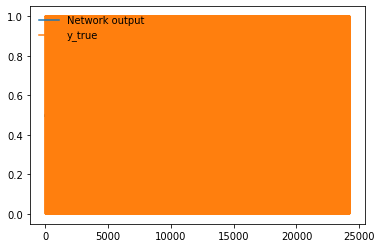

In [ ]:
for dataset in dataloader_test:
  sample = dataset['sampel']
  target = dataset['target']
  y_pred = t(sample.unsqueeze(2).float())
print(sample.shape, target.shape)

y_pred = (y_pred.detach().numpy().reshape(-1,1))
target = (target.detach().numpy().reshape(-1,1))

# y_pred = scaler.inverse_transform(y_pred.detach().numpy().reshape(-1,1))
# target = scaler.inverse_transform(target.detach().numpy().reshape(-1,1))
# y_pred
# target

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.clear()
ax.plot(y_pred, label='Network output')
ax.plot(target, label='y_true')
ax.set_title("")
ax.legend(loc='upper left', frameon=False);

print(np.sqrt(((y_pred - target)**2).mean()))

true_seq = target.flatten()
prediction = y_pred.flatten()

In [ ]:
true_seq.shape

(876, 1)

In [ ]:
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq})

##### from Yanine

CPU times: user 77 ms, sys: 1 ms, total: 78 ms
Wall time: 78.3 ms


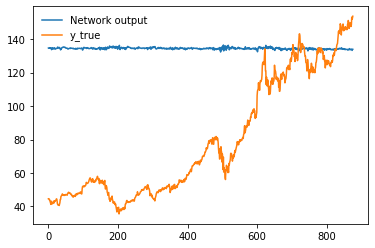

In [ ]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
#true_seq = scaler.inverse_transform(instrument_data.reshape(-1, 1))
x = [X_test[0].tolist()]
N = X_test.shape[0] #- (enc_seq_len + output_sequence_length)

#Draw graph 
for i in range(N): 
  q = torch.tensor([X_test[i].tolist()]).float()  
  
  #if(output_sequence_length == 1):
  y_pred = [t(q).detach().squeeze().numpy()]
  
  x[0].append(y_pred)

prediction = scaler.inverse_transform(x[0])
ax.clear()
ax.plot(prediction, label='Network output')
ax.plot(true_seq, label='y_true')
ax.set_title("")
ax.legend(loc='upper left', frameon=False);

prediction = prediction.flatten()

### 6. Оценка качества предсказаний

#### Pearson product-moment correlation coefficients

In [ ]:
true_seq = prediction.flatten()

np.corrcoef(prediction, true_seq[:-1])

#### RMSE

In [ ]:
np.sqrt(((prediction - true_seq[:-1])**2).sum())

ValueError: ignored

### 7. Финансовый результат

#### FOR RETURN

In [ ]:
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq[:-1]})
profit_table['forecast'] = np.where(profit_table['forec'] > 0, 1, -1)
profit_table['tru_label'] = np.where(profit_table['true_seq'] > 0, 1, -1)
profit_table['Accura']   = np.where(profit_table['forecast']*profit_table['tru_label'] == 1, 1, 0)
profit_table
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = 'forecast',
                values = ['true_seq', 'Accura'],
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

RuntimeError: ignored

#### FOR PRICE

In [ ]:
threshold = 0.
index_for = ['forecast_threshold']
 
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq[:-1]})
profit_table['Profit']   = ((profit_table['true_seq'].shift(-1) / profit_table['true_seq']- 1) * 100)
profit_table['Accura']   = np.where(profit_table['Profit'] > 0, 1, 0)
profit_table['Profit_forec']   = ((profit_table['forec'].shift(-1) / profit_table['forec']- 1) * 100)
profit_table['forecast'] = np.where((profit_table['forec'].shift(-1) / profit_table['forec']- 1) > 0, 1, -1)
profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
profit_table['Dif']      = (profit_table['true_seq'] - profit_table['forecast']) / profit_table['true_seq']  
profit_table['Data']     = np.array(year_test['<DATE>'][:-1])
profit_table['Data']     = np.array(pd.to_datetime(profit_table['Data']))
profit_table['Year'] = profit_table['Data'].dt.year
profit_table['Profit'] = np.where(profit_table['Profit']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit']))
profit_table['Profit_forec'] = np.where(profit_table['Profit_forec']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit_forec']))
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = index_for,
                values = ['Profit', 'Accura'],
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

count          mean       
                   Accura Profit Accura Profit
forecast_threshold                            
-1                    243    243   0.62   0.51
1                     511    511   0.54  -0.02
All                   754    754   0.57   0.15

# Обучение и прогнозирование в цикле

In [ ]:
all_prediction = pd.DataFrame()
 
for stock in os.listdir('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR)[:]  :
  print(stock)
  t = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
  optimizer = torch.optim.Adam(t.parameters(), lr=lr)   
  
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ROBO/Transformers/' + DIR +  stock)
  x = int(len(data)*0.7)
  close = '<CLOSE>'
  #  train data
  instrument_data, year_train = get_dummy_data(x, close = close)
  scaler = MinMaxScaler()
  instrument_data = scaler.fit_transform(instrument_data.reshape(-1, 1)).flatten()
 
  # test_data = np.arange(100, 150, dtype=np.float32)
  test_data, year_test = get_dummy_data_test(x, close = close)
  true_seq = test_data.copy()
 
  test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
  X_test, y_test = get_data(test_data, batch_size, enc_seq_len, output_sequence_length, False)
  print(instrument_data.shape, X_test.shape, y_test.shape)
 
  t = traina(instrument_data, epochs = 5, MY_FORCE=10)
  prediction = predi()

  # t, losses= train(instrument_data=instrument_data, batch_size=batch_size, epochs = 10)
  # prediction = pred(X_test=X_test, t = t)
 
  # prediction = prediction.flatten()
 
  all_prediction = pd.concat([all_prediction, pd.DataFrame({'forec': prediction, 'true_seq': true_seq[:-1], 'stock': stock.split('.')[-2]})])

# Pivot_table

In [ ]:
profit_table

,forec,true_seq,Profit,Profit_forec,forecast,forecast_threshold,Dif


In [ ]:
threshold = 0
index_for = [ 'forecast_threshold']
 
profit_table = pd.DataFrame({'forec':prediction, 'true_seq':true_seq})
# profit_table = all_prediction.copy()
profit_table['Profit']   = ((profit_table['true_seq'].shift(-1) / profit_table['true_seq']- 1) * 100)
profit_table['Profit_forec']   = ((profit_table['forec'].shift(-1) / profit_table['forec']- 1) * 100)
profit_table['forecast'] = np.where((profit_table['forec'].shift(-1) / profit_table['forec']- 1) > 0, 1, -1)
profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
profit_table['Dif']      = (profit_table['true_seq'] - profit_table['forecast']) / profit_table['true_seq']  
# profit_table['Data']     = year_test['<DATE>']
# profit_table['Data']     = np.array(pd.to_datetime(profit_table['Data']))
# profit_table['Year'] = profit_table['Data'].dt.year
profit_table['Profit'] = np.where(profit_table['Profit']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit']))
profit_table['Profit_forec'] = np.where(profit_table['Profit_forec']>20, 20, np.where(profit_table['Profit']<-20, -20, profit_table['Profit_forec']))
profit_table.dropna(inplace = True)
pd.pivot_table(profit_table,
                index = index_for,
                values = 'Profit',
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2)

,count
,Profit
forecast_threshold,
All,0


In [ ]:
profit_table.to_excel(PATH + 'frts.xlsx')

In [ ]:
def pivot(threshold = 0.1, index_for = 'forecast'):
  profit_table = pd.DataFrame({'prediction':prediction, 'true':true_seq[:-1]})
  profit_table['Profit']   = ((profit_table['true'].shift(-1) / profit_table['true']- 1) * 100)
  profit_table['Profit_forec']   = ((profit_table['prediction'].shift(-1) / profit_table['prediction']- 1) * 100)
  profit_table['forecast'] = np.where((profit_table['prediction'].shift(-1) / profit_table['prediction']- 1) > 0, 1, -1)
  profit_table['forecast_threshold'] = np.where(profit_table['Profit_forec']> threshold, 1, np.where(profit_table['Profit_forec'] < - threshold, -1, 0))
  profit_table['Dif']      = (profit_table['true'] - profit_table['forecast']) / profit_table['true']  
  profit_table['Data']     = data['<DATE>']
  profit_table['Year'] = profit_table['Data'].dt.year
  profit_table.dropna(inplace = True)
  return pd.pivot_table(profit_table,
                index = [index_for],
                values = 'Profit',
                aggfunc = ['count', 'mean'],
                margins = True
                ).round(2), profit_table

In [ ]:
_, profit_table = pivot(index_for='forecast_threshold')
profit_table
print(_,)

                    count   mean
                   Profit Profit
forecast_threshold              
-1                    187   0.21
0                      31   0.24
1                     229   0.56
All                   447   0.39
